# Libraries

In [1]:
import numpy as np
import pandas as pd
import os

# Load Data

In [2]:
# Data reading OK
print(os.listdir("./input/home-data-for-ml-course"))

['train.csv.gz', 'sample_submission.csv', 'sample_submission.csv.gz', 'data_description.txt', 'test.csv.gz', 'test.csv', 'train.csv']


In [3]:
# Loading data

train=pd.read_csv('./input/home-data-for-ml-course/train.csv')
test=pd.read_csv('./input/home-data-for-ml-course/test.csv')

# Data Analysis

In [4]:
# Data look up
train.drop('Id',axis=1, inplace=True)
test.drop('Id',axis=1, inplace=True)
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
# Calculating NaN percentage
def nans_ratio(train):
    """calculate the nan ratio in a df"""
    total_nans = train.isna().sum().sum()
    total_cells = train.count().sum()
    nans_ratio = total_nans / total_cells
    return nans_ratio
nans_ratio(train)

0.06341330177083808

## Treating NaN values

### Alley

In [7]:
# the data description indicates that NA as 'No alley' ot 'Not Apply', so we will turn this NaN into 'NA'
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [8]:
train['Alley'].fillna('NA', inplace=True)
train['Alley'].value_counts()

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

### Other features

In [9]:
# The same problems was founded in several features that include 'NA' in it's values
# NaN values will be replaced with 'NA' in the following features
nan_features = ['Alley','FireplaceQu', 'PoolQC','Fence','MiscFeature','GarageType','GarageFinish','GarageQual',
                'GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for f in nan_features:
    train[f].fillna('NA', inplace=True)

In [10]:
train['PoolQC'].value_counts()

NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

In [11]:
# Doing the same for the test set
for f in nan_features:
    test[f].fillna('NA', inplace=True)

In [12]:
# For 'GarageYrBlt', if there is no garage, it will be filled with 0
# The same will be donde for 'LotFrontage', assuming that NaN is equalo to 0 or no front.
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
train['LotFrontage'].fillna(0, inplace=True)
test['LotFrontage'].fillna(0, inplace=True)

In [13]:
# Check info
nans_ratio(train)

0.00014556913249359925

### Drop the rest of the NaN rows

To avoid further problems, the rest of the Nulls/Nans rows will be droped

In [14]:
# Train
train = train.dropna()
train = train.reset_index(drop=True)
# Test
test = test.dropna()
test = test.reset_index(drop=True)

In [15]:
nans_ratio(train)

0.0

## Treating categorical data

Because there are son many features with categorical data, using dummy for all variables will leave the df with hundreds columns more.
Also, many of the categorical features have some ordinal properties, so we want to keep that information. Variables will be processed to asign numerical values going from 0 (worst) to n (best) (n=number of labels)

I.e. 

AllPub	All public Utilities (E,G,W,& S)	-->3

NoSewr	Electricity, Gas, and Water (Septic Tank) -->2

NoSeWa	Electricity and Gas Only  --> 1

ELO	Electricity only	--> 0

This process will be done automatically, grouping by the feature and ranking by the mean of the target (SalePrice).

For more info, look at data_description.txt

### Categorical encoding function


In [16]:
#SalePrice-> group_by MSZoning -> mean
train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=True)

MSZoning
C (all)     74528.000000
RM         126316.830275
RH         131558.375000
RL         190720.720524
FV         214888.129032
Name: SalePrice, dtype: float64

In [17]:
train["MSZoning"].value_counts()

RL         1145
RM          218
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [18]:
labels = train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=True).index
labels

Index(['C (all)', 'RM', 'RH', 'RL', 'FV'], dtype='object', name='MSZoning')

In [19]:
for i,label in enumerate(labels):
    train.loc[train["MSZoning"] == label, "MSZoning"] = int(i)
    test.loc[test["MSZoning"] == label, "MSZoning"] = int(i)
train["MSZoning"] = train["MSZoning"].astype(int)
test["MSZoning"] = test["MSZoning"].astype(int)

In [20]:
train["MSZoning"].value_counts()

3    1145
1     218
4      62
2      16
0      10
Name: MSZoning, dtype: int64

In [21]:
def encode_categorical(feature):
    """
    Giving a feature f, encodes the categorical feature
    into integers from 0 to n-1 taking in account the 
    correlation with the target SalePrice
    """
    labels = train.groupby(feature)['SalePrice'].mean().sort_values(ascending=True).index
    for i,label in enumerate(labels):
        train.loc[train[feature] == label, feature] = i
        test.loc[test[feature] == label, feature] = i
    train[feature] = train[feature].astype(int)
    test[feature] = test[feature].astype(int)

## Ordinal categorical encoding

In [22]:
# Encoding train and test df

for column in train.columns:
    # if the dtype of the column is object
    if train[column].dtype == 'object':
        encode_categorical(column)
        


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1431 non-null   int64  
 1   MSZoning       1431 non-null   int64  
 2   LotFrontage    1431 non-null   float64
 3   LotArea        1431 non-null   int64  
 4   Street         1431 non-null   int64  
 5   Alley          1431 non-null   int64  
 6   LotShape       1431 non-null   int64  
 7   LandContour    1431 non-null   int64  
 8   Utilities      1431 non-null   int64  
 9   LotConfig      1431 non-null   int64  
 10  LandSlope      1431 non-null   int64  
 11  Neighborhood   1431 non-null   int64  
 12  Condition1     1431 non-null   int64  
 13  Condition2     1431 non-null   int64  
 14  BldgType       1431 non-null   int64  
 15  HouseStyle     1431 non-null   int64  
 16  OverallQual    1431 non-null   int64  
 17  OverallCond    1431 non-null   int64  
 18  YearBuil

## Data Normalization for Numeric features

In this version, and according to the hist of each feature, I will normalize the data just by dividing it by it range

In [24]:
rang_dict = dict()

for column in train.columns:
    rang = train[column].max()-train[column].min()
    train[column] = train[column].div(rang)
    rang_dict[column] = rang
    

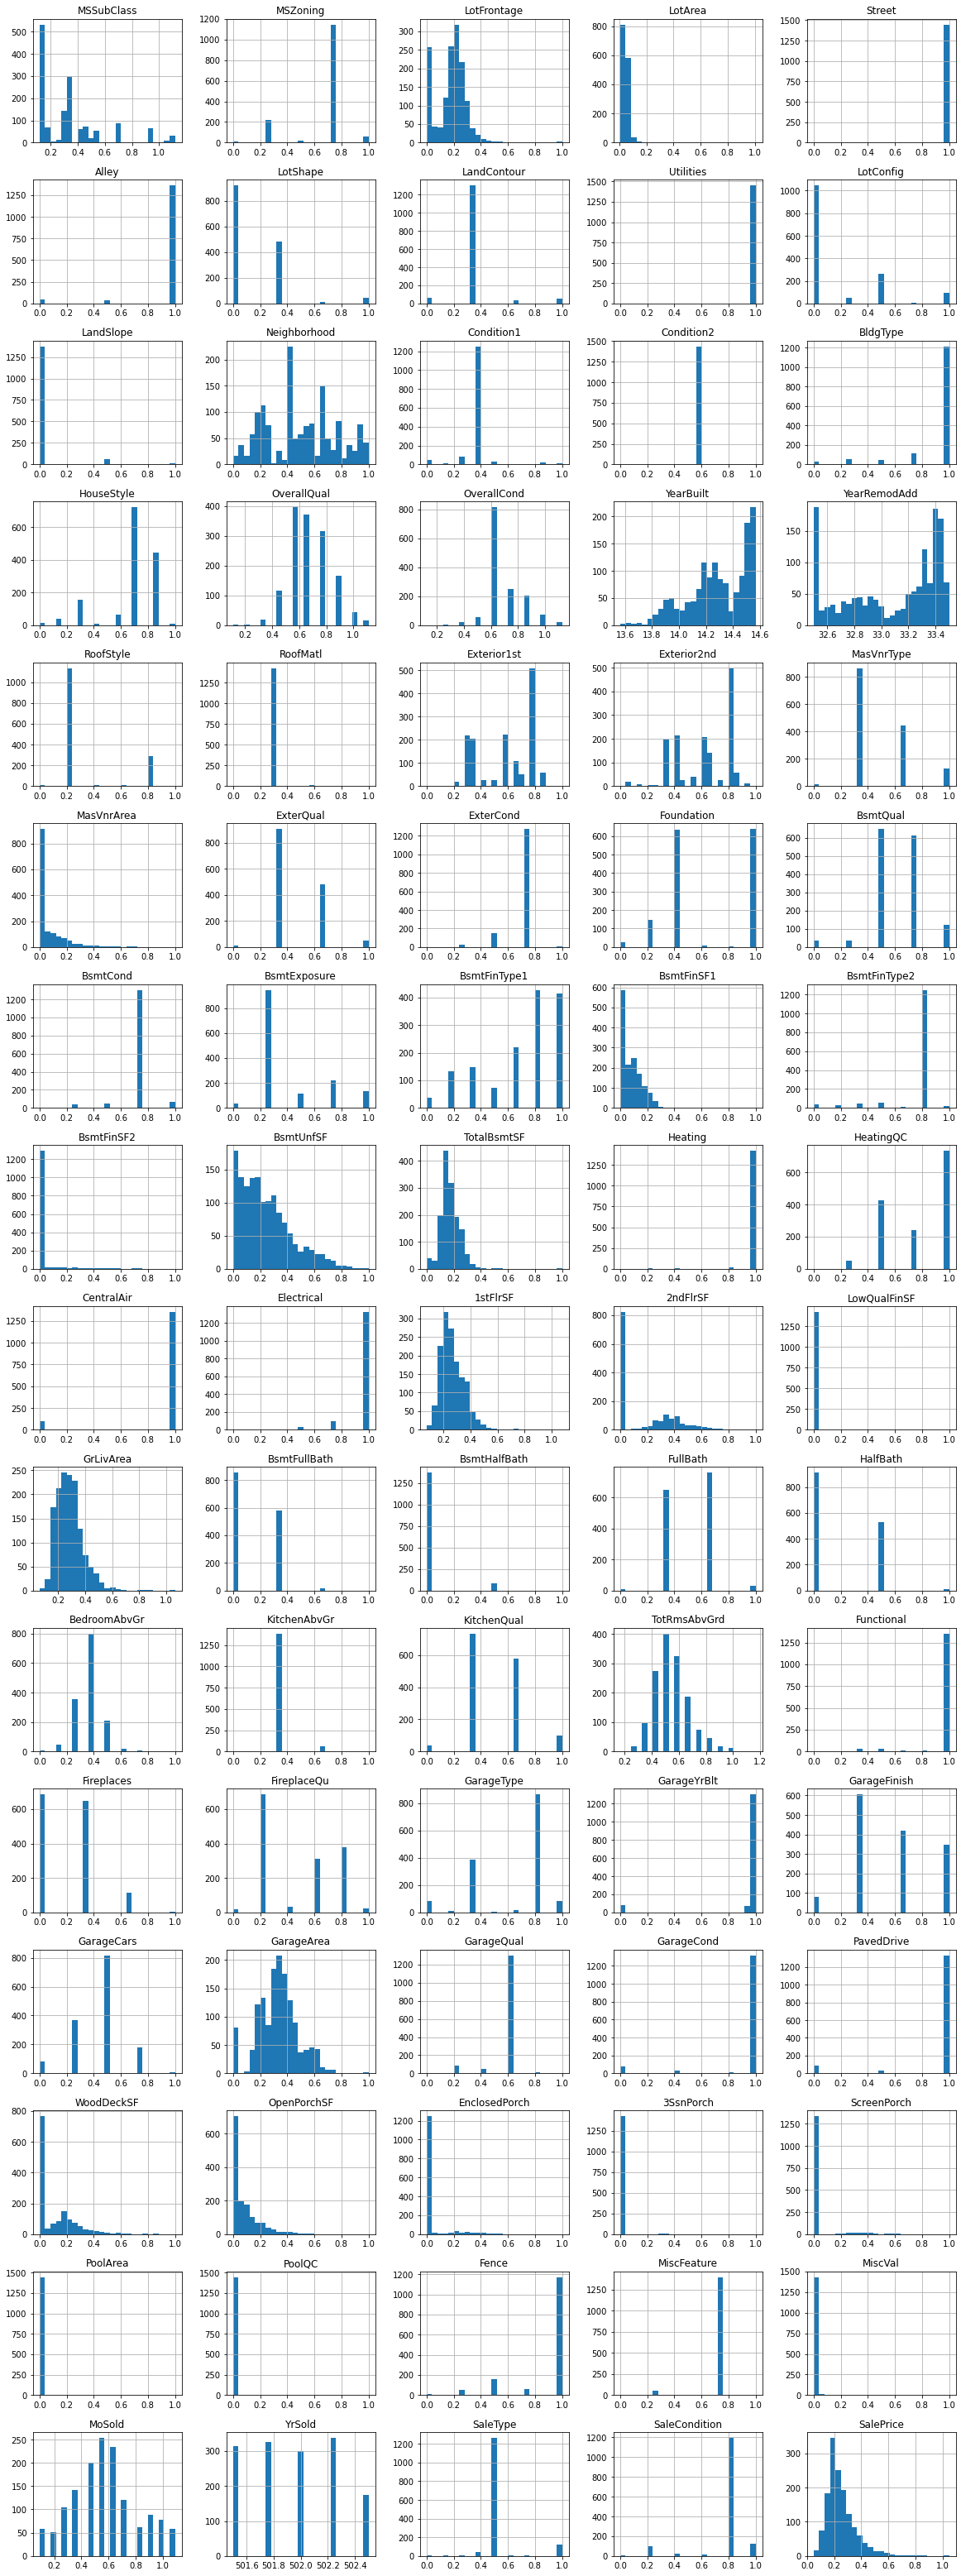

In [25]:
train.hist(bins=25, figsize=(20,60), layout=(17,5));

In [27]:
train.to_csv('train_fe.csv')
test.to_csv('test_fe.csv')


## Notes

- I should also save the range_dict to use later
- Read skl pp MinMaxScaler